In [1]:
import sys
sys.path.append('..')
import spark

import copy
import jax
import jax.numpy as jnp
import numpy as np
import gymnasium as gym
import ale_py
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
import datetime
gym.register_envs(ale_py)

from IPython.display import display

from cartpole import (
    ALIFNeuronModulation, ALIFNeuronModulationConfig,
    run_model_scan, run_model_and_record_scan, process_obs, compute_real_reward, compute_test_plot, build_brain, random_model, plot_kernels
)

graph = None

In [2]:
if False:
	quadruplet_config = spark.nn.learning_rules.QuadrupletRuleTensorConfig(
		pre_tau = 	(1/0.042,	1/0.091,	1/0.082,	1/0.041),
		post_tau = 	(1/0.076, 	1/0.050, 	1/0.082, 	1/0.059),
		q_alpha = 	(  0.718, 	  0.910, 	 -0.469, 	 -0.054),
		q_beta = 	( -0.572, 	 -1.000, 	  0.000, 	 -0.047),
		q_gamma = 	( -0.826, 	  1.453, 	  1.634, 	  1.580),
		q_delta = 	( -0.563, 	 -0.130, 	  1.529, 	 -0.435),
		max_clip =  (   50.0, 	   50.0, 	   100.0,     100.0),
		eta = 0.1,
	)
	# 4baeb
	quadruplet_config = spark.nn.learning_rules.QuadrupletRuleTensorConfig(
		pre_tau = 	(1/0.080,	1/0.077,	1/0.075,	1/0.052),
		post_tau = 	(1/0.054, 	1/0.060, 	1/0.051, 	1/0.083),
		q_alpha = 	(  0.774, 	  1.652, 	 -0.733, 	 -0.318),
		q_beta = 	( -0.634, 	 -1.134, 	  1.522, 	 -0.251),
		q_gamma = 	( -1.669, 	  1.722, 	  0.551, 	  1.065),
		q_delta = 	(  0.525, 	 -1.104, 	 -0.936, 	  1.227),
		max_clip =  (   50.0, 	   50.0, 	   100.0,     100.0),
		eta = 0.1,
	)
# a00fe
quadruplet_config = spark.nn.learning_rules.QuadrupletRuleTensorConfig(
	pre_tau = 	(1/0.093,	1/0.066,	1/0.096,	1/0.013),
	post_tau = 	(1/0.071, 	1/0.037, 	1/0.062, 	1/0.078),
	q_alpha = 	(  1.207, 	  1.037, 	 -1.152, 	 -1.336),
	q_beta = 	( -1.298, 	 -1.205, 	  1.639, 	  1.057),
	q_gamma = 	(  0.398, 	  1.589, 	  1.790, 	 -1.173),
	q_delta = 	( -0.750, 	  0.408, 	 -1.666, 	  1.557),
	max_clip =  (   50.0, 	   50.0, 	   100.0,     100.0),
	eta = 0.1,
)
ex_config = ALIFNeuronModulationConfig(
	_s_units = (256,),
	inhibitory_rate = 0.0,
	soma = spark.nn.somas.AdaptiveLeakySomaConfig(
		cooldown = 2.0,
		potential_tau = 10.0,
		threshold_tau = 10.0,
		threshold_delta = 50.0,
	),
	synapses = spark.nn.synapses.TracedSynapsesConfig(
        tau = 5.0,
		kernel__scale = 15.0,
		kernel__density = 0.05,
		kernel__min_value = 0.0,
		kernel__max_value = 15.0,
	),
	delays = spark.nn.delays.N2NDelaysConfig(
		max_delay = 4.0
	),
	learning_rule = quadruplet_config
)

in_config = ALIFNeuronModulationConfig(
	_s_units = (64,),
	inhibitory_rate = 1.0,
	soma = spark.nn.somas.AdaptiveLeakySomaConfig(
		cooldown = 1.0,
		potential_tau = 20.0,
		threshold_tau = 10.0,
		threshold_delta = 20.0,
	),
	synapses = spark.nn.synapses.TracedSynapsesConfig(
        tau = 10.0,
		kernel__scale = 10.0,
		kernel__density = 0.05,
		kernel__min_value = 0.0,
		kernel__max_value = 10.0,
	),
	delays = spark.nn.delays.N2NDelaysConfig(
		max_delay = 4.0
	),
	learning_rule = quadruplet_config
)

#brain_path = build_brain(ex_config, in_config, dt=1.0, dir_path='models')
#brain_path = build_brain(ex_config, in_config, dt=1.0, dir_path='models')
#brain_path = 'models/ab_cartpole_model_12_13_2025_17_32_46.scfg'
brain_path = 'models/ab_cartpole_model_12_15_2025_14_57_57.scfg'

[ True  True  True  True  True  True  True  True  True]


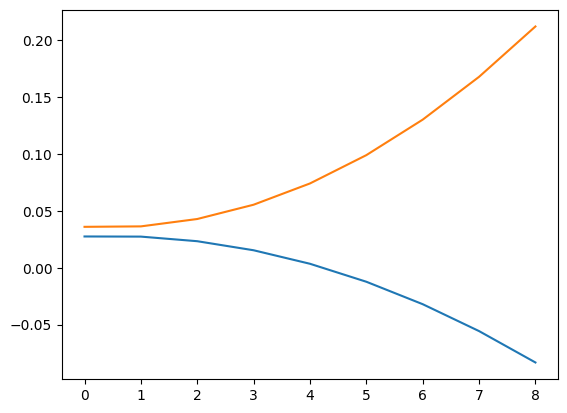

[ True  True  True  True  True False False False False False False]


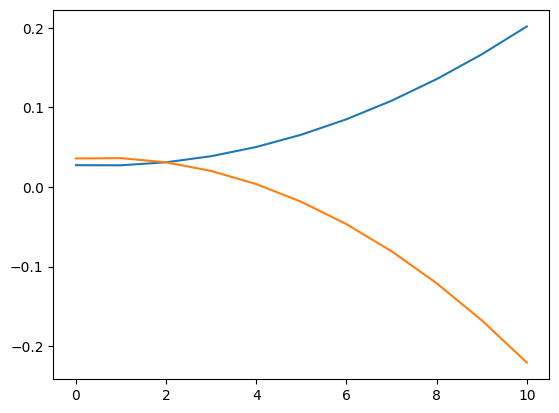

In [3]:
env_name =  'CartPole-v1'
env = gym.make(env_name, sutton_barto_reward=True)

next_obs, _ = env.reset(seed=42)
obs = []
obs.append(next_obs)
for i in range(10):
	next_obs, reward, terminated, truncated, info = env.step(0)
	obs.append(next_obs)
	if terminated:
		break
obs = np.array(obs)
plt.plot(obs[:,0])
plt.plot(obs[:,2])
print(obs[:,2] > 0)
plt.show()
next_obs, _ = env.reset(seed=42)
obs = []
obs.append(next_obs)
for i in range(10):
	next_obs, reward, terminated, truncated, info = env.step(1)
	obs.append(next_obs)
	if terminated:
		break
obs = np.array(obs)
plt.plot(obs[:,0])
plt.plot(obs[:,2])
print(obs[:,2] > 0)

In [4]:
env_name =  'CartPole-v1'
env = gym.make(env_name, sutton_barto_reward=True)
next_obs, _ = env.reset(seed=42)
next_obs = process_obs(next_obs)

DT=1.0
STEPS = int(50/DT)
MODULATION_DECAY = float(np.exp(-DT / 0.5))
TRAIN_EPOCHES = 3000
TEST_EPOCHES = 10
UNROLL = 15

In [5]:
# Load the Brain.
brain_config = spark.nn.BrainConfig.from_file(brain_path)

# Reset graph on config update. (NOTE: Shape preserving updates are safe and graph reset may be skipped)
#graph = None

# Initialize the Brain.
brain = spark.nn.Brain(config=brain_config, _s_dt=DT)

# Build the Brain.
inputs = {
	'drive': spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)),
	'mod_a_ex': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
	'mod_a_in': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
	'mod_b_ex': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
	'mod_b_in': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
}
brain(**inputs)

# Split brain into the graph and the state
#  Notebook-Hack: Skip graph re-initialization on compatible models.
if graph is None:
	graph, state = spark.split((brain))
else: 
	_, state = spark.split((brain))
      
# Compitle runtime fn. Depending on the number of steps this may take a little bit of time.
output_spikes_order = ('spiker', 'A_ex', 'A_in', 'B_ex', 'B_in')
out, state = run_model_scan(
	graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, **inputs
)
out, state, model_spikes = run_model_and_record_scan(
	graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, output_order=output_spikes_order, **inputs
)

In [6]:
def compute_real_reward(x, x_prev, terminated, truncated):
	# CartPos, CartSpeed, PoleAngle, PoleAngSpeed 
	if truncated:
		return 1
	elif terminated:
		return -1
	# Try to keep the cart centered
	pos_term = -(x[0]**2 - x_prev[0]**2)
	pos_term = np.sign(pos_term) * np.sqrt(np.abs(pos_term))
	# Try to keep the pole balanced
	angle_term = -(x[2]**2 - x_prev[2]**2)
	angle_term = np.sign(angle_term) * np.sqrt(np.abs(angle_term))
	r = np.clip(angle_term, a_min=-1, a_max=1)
	#r = np.clip(0.9 * angle_term + 0.1 * pos_term, a_min=-1, a_max=1)
	return r

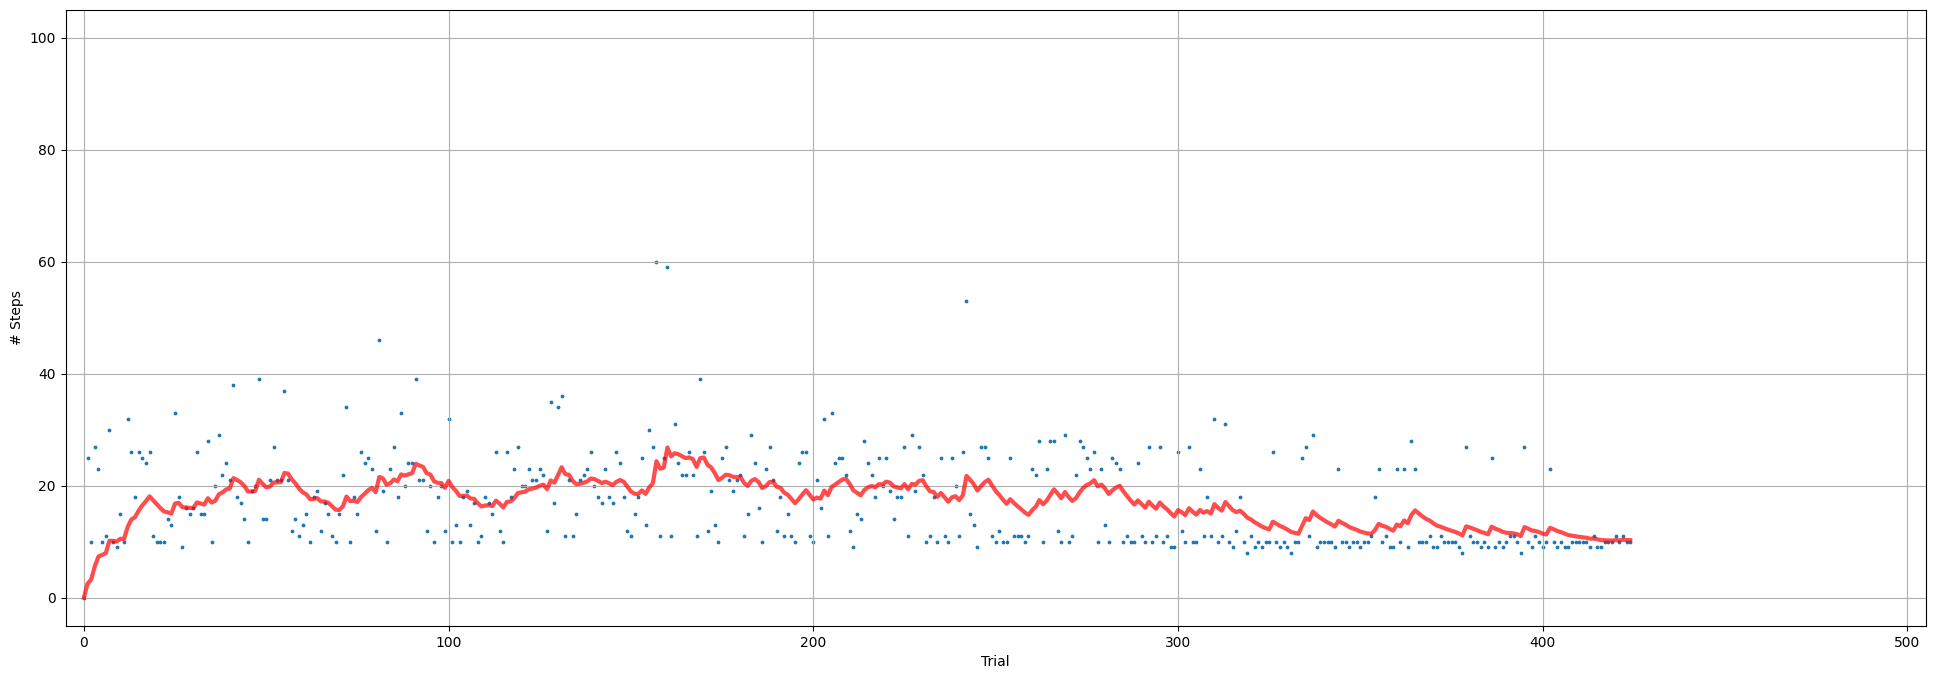

 14%|█▍        | 424/3000 [00:53<05:22,  7.98it/s]


KeyboardInterrupt: 

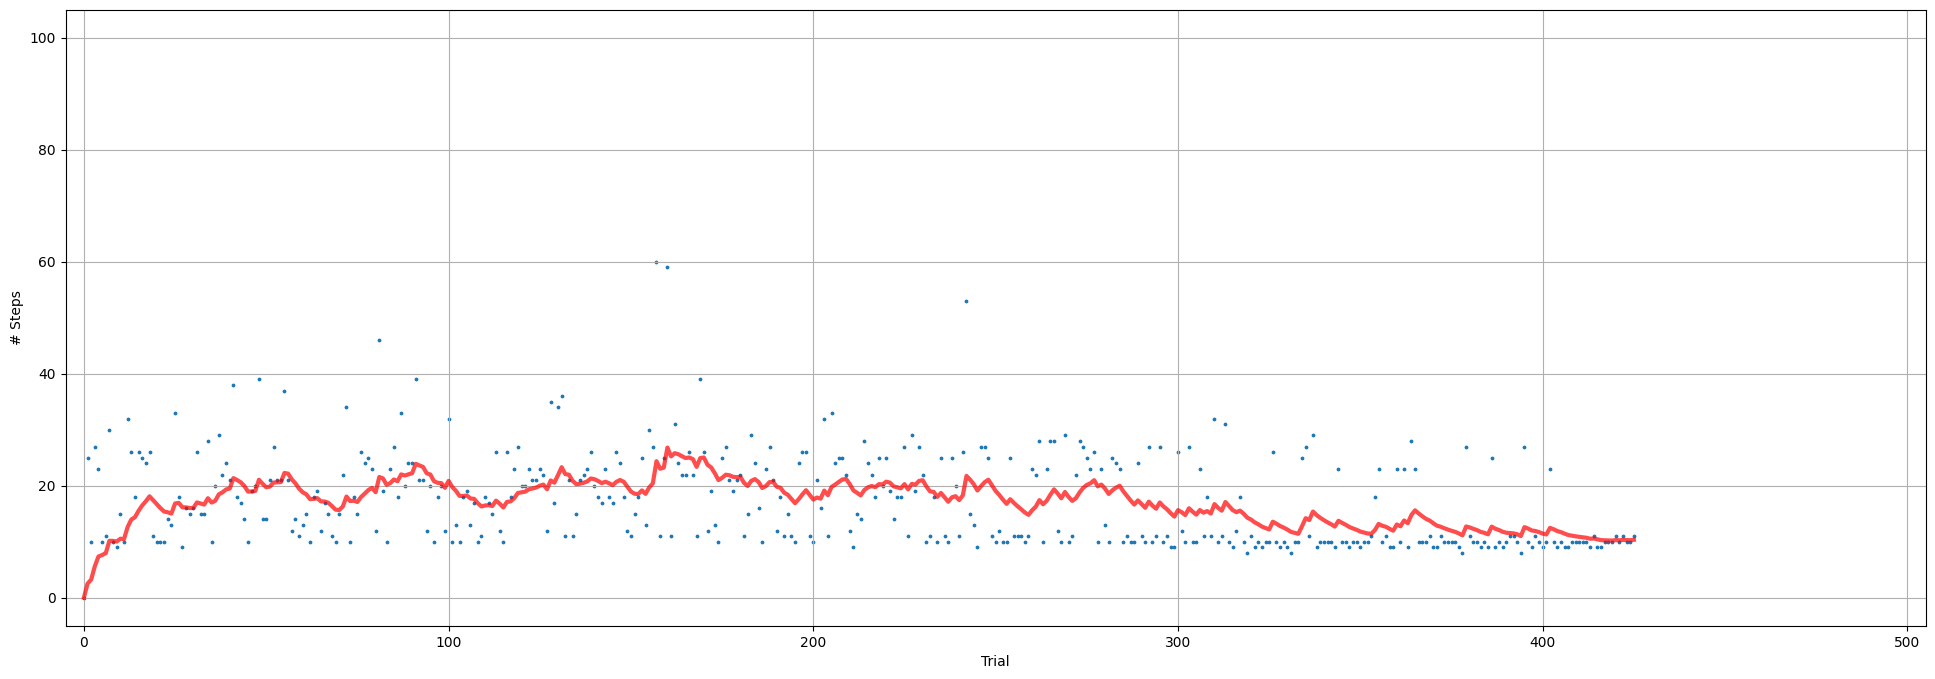

In [7]:
MODULATION_DECAY = float(np.exp(-DT / 0.5))

# Create handle for dynamic plotting
fig, ax = plt.subplots(figsize=(24,8))
(line,) = ax.plot([], [], 'r', linewidth=3, alpha=0.7)
points = ax.scatter([], [], s=3)
ax.set_xlabel('Trial')
ax.set_ylabel('# Steps')
ax.grid()
handle = display(fig, display_id=True)
current_xlim, current_ylim = 100, 100
# A fresh brain state
_, state = spark.split((brain))
# A fresh environment
next_obs, _ = env.reset(seed=42)
prev_obs = next_obs
reward = 0
prev_action, next_action = 0, 0
reward_leak = -1.0#1.0#0.01
reward_scale = 2.0

reward_leak_ex = -1.0
reward_leak_in = -1.0
end_episode_reward_scale_in = 0.5
end_episode_reward_scale_ex = 0.5

# Some classic training loop.
steps = [0]
ema_alpha, steps_ema = 0.9, [0]
for i in tqdm(range(TRAIN_EPOCHES)):
	terminated = False
	truncated = False
	tmp_step = 0
	while not (terminated or truncated):
		# Model logic
		#dyn_reward_scale = (1 - (steps_ema / 500))# * reward_scale
		#reward = reward_scale * compute_real_reward(next_obs, prev_obs, terminated, truncated) #* np.array(np.random.rand() < 0.1).astype(float)
		passive_mod = 0.00001 * (1 - (steps_ema[-1] / 500))**2 #0*(1 - (tmp_step / 500)) * 0.001
		mod_a_ex = passive_mod#reward if prev_action == 0 else reward_leak * reward
		mod_b_in = passive_mod#-reward if prev_action == 0 else -reward_leak * reward
		mod_b_ex = passive_mod#reward if prev_action == 1 else reward_leak * reward
		mod_a_in = passive_mod#-reward if prev_action == 1 else -reward_leak * reward
		inputs = {
			'drive': spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)),
			'mod_a_ex': spark.FloatArray(jnp.array([mod_a_ex], dtype=jnp.float16)),
			'mod_a_in': spark.FloatArray(jnp.array([mod_a_in], dtype=jnp.float16)),
			'mod_b_ex': spark.FloatArray(jnp.array([mod_b_ex], dtype=jnp.float16)),
			'mod_b_in': spark.FloatArray(jnp.array([mod_b_in], dtype=jnp.float16)),
		}
		out, state = run_model_scan(graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, **inputs)
		# Environment logic.
		prev_action = np.array(next_action)
		prev_obs = np.array(next_obs)
		next_action = int(np.argmax(out['action'].value))
		next_obs, reward, terminated, truncated, info = env.step(next_action)
		next_obs = process_obs(next_obs)
		tmp_step += 1
	steps.append(tmp_step)
	steps_ema.append(ema_alpha * steps_ema[-1] + (1-ema_alpha) * tmp_step)
	#steps[i] = tmp_step

	# One extra step with the reward
	reward = 0.1*(1 - (tmp_step / 500))
	# If side is > 0 we need to steer to one (B)
	side = next_obs[2] > 0
	#reward = dyn_reward_scale * dyn_reward_scale*compute_real_reward(next_obs, prev_obs, terminated, truncated) 
	mod_a_ex = reward * end_episode_reward_scale_ex if not side else reward_leak_ex * reward * end_episode_reward_scale_ex
	mod_a_in = reward * end_episode_reward_scale_in if not side else reward_leak_in * reward * end_episode_reward_scale_in
	mod_b_in = reward * end_episode_reward_scale_in if side else reward_leak_in * reward * end_episode_reward_scale_in
	mod_b_ex = reward * end_episode_reward_scale_ex if side else reward_leak_ex * reward * end_episode_reward_scale_ex
	for _ in range(1):
		inputs = {
			'drive': spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)),
			'mod_a_ex': spark.FloatArray(jnp.array([mod_a_ex], dtype=jnp.float16)),
			'mod_a_in': spark.FloatArray(jnp.array([mod_a_in], dtype=jnp.float16)),
			'mod_b_ex': spark.FloatArray(jnp.array([mod_b_ex], dtype=jnp.float16)),
			'mod_b_in': spark.FloatArray(jnp.array([mod_b_in], dtype=jnp.float16)),
		}
		_, state = run_model_scan(graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, **inputs)

	# Reset environment
	next_obs, _ = env.reset()
	reward = 0
	for _ in range(1):
		inputs = {
			'drive': spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)),
			'mod_a_ex': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
			'mod_a_in': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
			'mod_b_ex': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
			'mod_b_in': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
		}
		_, state = run_model_scan(graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, **inputs)

	# Update line and redraw
	pts = np.stack([np.arange(len(steps)),steps]).T
	ln = np.stack([np.arange(len(steps_ema)),steps_ema])
	while np.max(steps) > current_ylim + 1:
		current_ylim += 100
	while len(steps) > current_xlim:
		current_xlim += 100
	ax.set_ylim(-5, current_ylim+5)
	ax.set_xlim(-5, current_xlim+5)
	points.set_offsets(pts)
	line.set_data(ln)
	fig.canvas.draw()
	handle.update(fig)

	# Display kernels every now and then...
	if False and i % 100 == 0:
		current_brain = spark.merge(graph, state)
		current_kernels = (
			jnp.array(current_brain.A_ex.synapses.kernel.value),
			jnp.array(current_brain.A_in.synapses.kernel.value),
			jnp.array(current_brain.B_ex.synapses.kernel.value),
			jnp.array(current_brain.B_in.synapses.kernel.value),
		)
		labels = ('A_ex', 'A_in', 'B_ex', 'B_in')
		ker_fig, ker_ax = plt.subplots(1,4, figsize=(20,4))
		for j in range(4):
			im = ker_ax[j].imshow(current_kernels[j], aspect='auto', interpolation='none')
			ker_ax[j].set_title(labels[j])
			ker_fig.colorbar(im, ax=ker_ax[j])
		ker_fig.suptitle(f'Kernels (Trials: {i})')
		plt.show()

In [ ]:
#np.save('./ab_cartpole_steps.npy', steps)
#np.save('./ab_cartpole_steps_ema.npy', steps_ema)

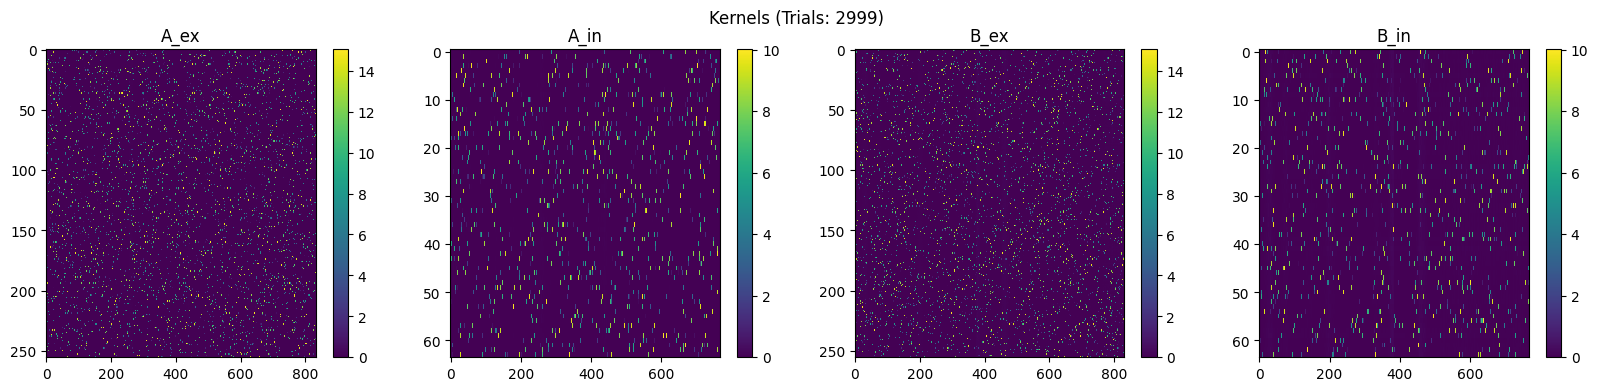

In [ ]:
plot_kernels(graph, state)

In [ ]:
def plot_kernels(graph, state):
	current_brain = spark.merge(graph, state)
	current_kernels = (
		jnp.array(current_brain.A_ex.synapses.kernel.value),
		jnp.array(current_brain.A_in.synapses.kernel.value),
		jnp.array(current_brain.B_ex.synapses.kernel.value),
		jnp.array(current_brain.B_in.synapses.kernel.value),
	)
	labels = ('A_ex', 'A_in', 'B_ex', 'B_in')
	ker_fig, ker_ax = plt.subplots(1,4, figsize=(20,4))
	for j in range(4):
		im = ker_ax[j].imshow(current_kernels[j], aspect='auto', interpolation='none')
		ker_ax[j].set_title(labels[j])
		ker_fig.colorbar(im, ax=ker_ax[j])
	ker_fig.suptitle(f'Kernels (Trials: {i})')
	plt.show()





----------------------------------------------------------------------------------------
tau: 1.0 	 scale_in: 1.0
----------------------------------------------------------------------------------------


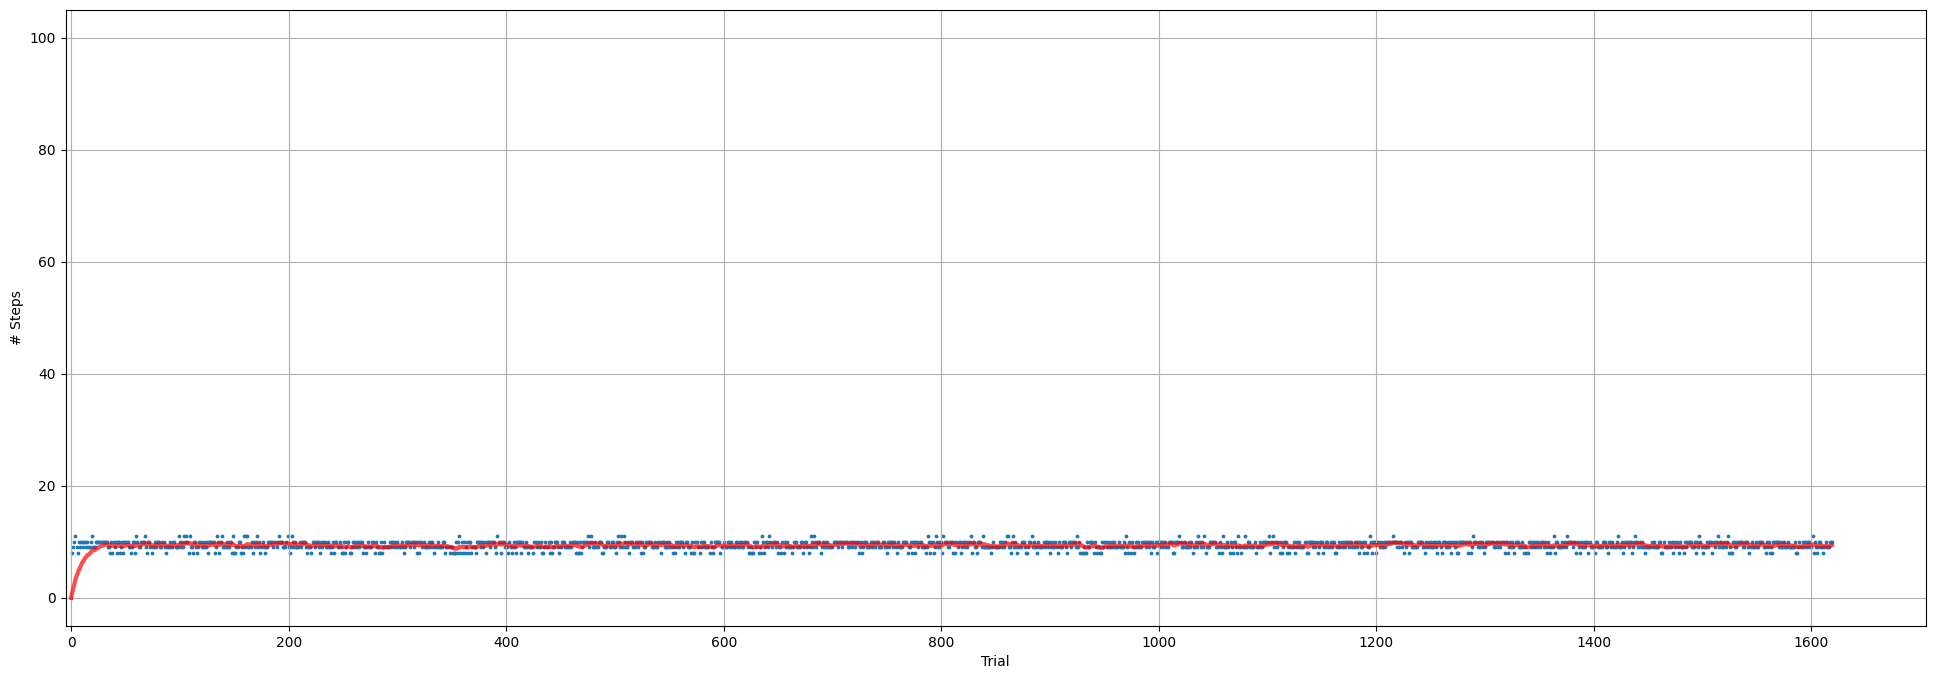

 81%|████████  | 1619/2000 [02:48<00:39,  9.59it/s]


KeyboardInterrupt: 

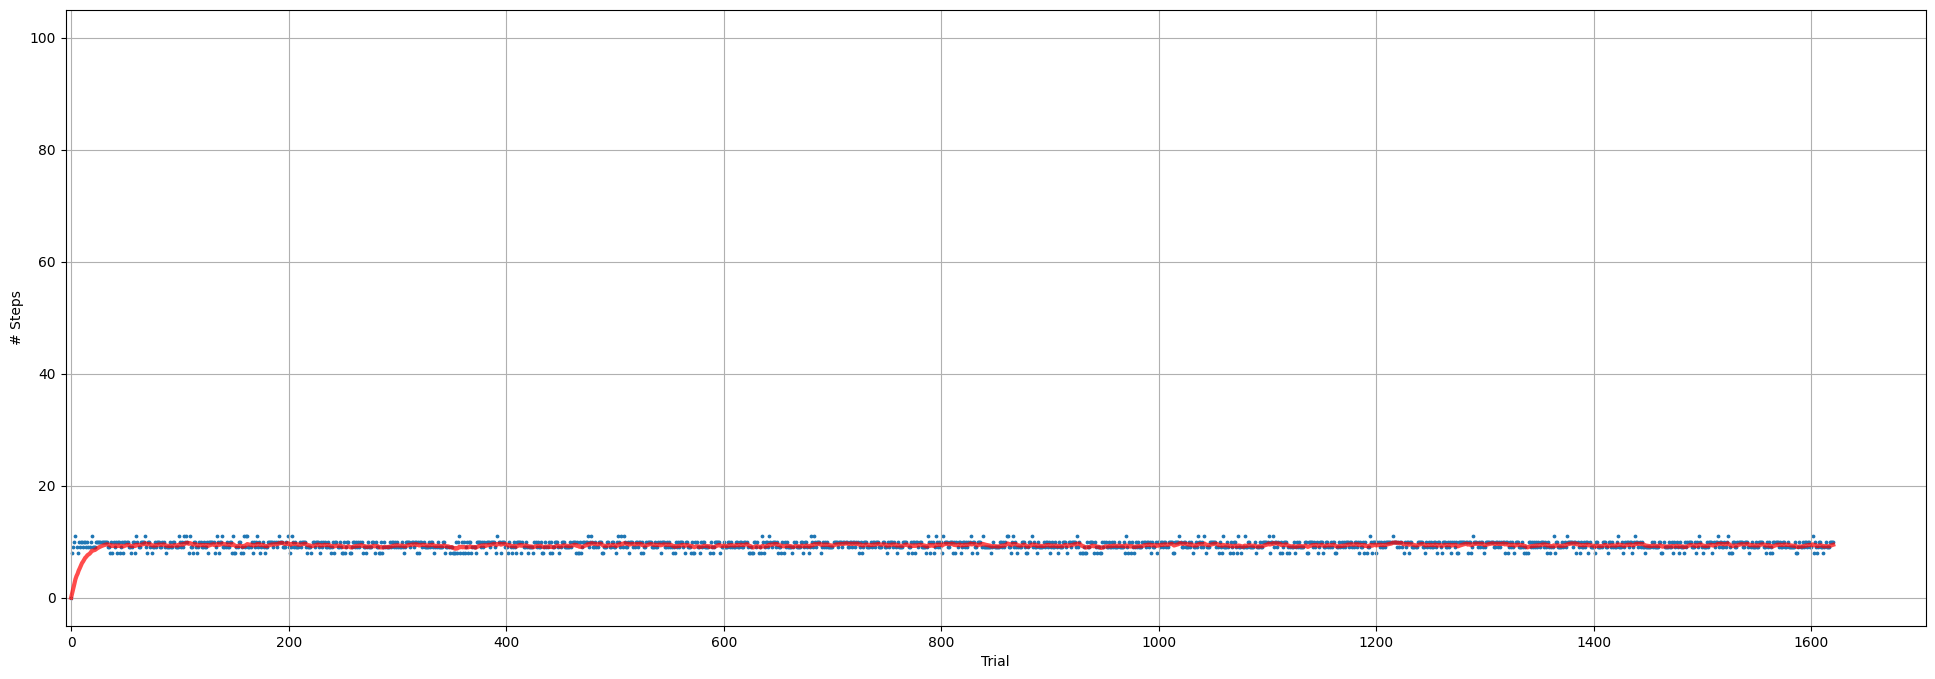

In [ ]:
for tau in [0.5]:
	MODULATION_DECAY = float(np.exp(-DT / tau))
	for scale_in in [1.00]:
		for scale_ex in [-1.0]:
			for passive in [0.01]:
					
				print('\n\n\n')
				print('----------------------------------------------------------------------------------------')
				print(f'tau: {tau} \t scale_in: {scale_in} \t scale_ex: {scale_ex} \t scale_ex: {passive}')
				print('----------------------------------------------------------------------------------------')

				# Create handle for dynamic plotting
				fig, ax = plt.subplots(figsize=(24,8))
				(line,) = ax.plot([], [], 'r', linewidth=3, alpha=0.7)
				points = ax.scatter([], [], s=3)
				ax.set_xlabel('Trial')
				ax.set_ylabel('# Steps')
				ax.grid()
				handle = display(fig, display_id=True)
				current_xlim, current_ylim = 100, 100
				# A fresh brain state
				_, state = spark.split((brain))
				# A fresh environment
				next_obs, _ = env.reset(seed=42)
				prev_obs = next_obs
				reward = 0
				prev_action, next_action = 0, 0
				reward_leak = -1.0#1.0#0.01
				reward_scale = 2.0

				reward_leak_ex = -1.0
				reward_leak_in = -1.0
				end_episode_reward_scale_in = scale_in
				end_episode_reward_scale_ex = scale_ex
				

				# Some classic training loop.
				steps = [0]
				ema_alpha, steps_ema = 0.9, [0]
				for i in tqdm(range(TRAIN_EPOCHES)):
					terminated = False
					truncated = False
					tmp_step = 0
					while not (terminated or truncated):
						# Model logic
						#dyn_reward_scale = (1 - (tmp_step / 500)) * reward_scale
						reward = reward_scale * compute_real_reward(next_obs, prev_obs, terminated, truncated) #* np.array(np.random.rand() < 0.1).astype(float)
						passive_mod = (1 - (tmp_step / 500)) * 0.001
						mod_a_ex = passive_mod#reward if prev_action == 0 else reward_leak * reward
						mod_b_in = passive_mod#-reward if prev_action == 0 else -reward_leak * reward
						mod_b_ex = passive_mod#reward if prev_action == 1 else reward_leak * reward
						mod_a_in = passive_mod#-reward if prev_action == 1 else -reward_leak * reward
						inputs = {
							'drive': spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)),
							'mod_a_ex': spark.FloatArray(jnp.array([mod_a_ex], dtype=jnp.float16)),
							'mod_a_in': spark.FloatArray(jnp.array([mod_a_in], dtype=jnp.float16)),
							'mod_b_ex': spark.FloatArray(jnp.array([mod_b_ex], dtype=jnp.float16)),
							'mod_b_in': spark.FloatArray(jnp.array([mod_b_in], dtype=jnp.float16)),
						}
						out, state = run_model_scan(graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, **inputs)
						# Environment logic.
						prev_action = np.array(next_action)
						prev_obs = np.array(next_obs)
						next_action = int(np.argmax(out['action'].value))
						next_obs, reward, terminated, truncated, info = env.step(next_action)
						next_obs = process_obs(next_obs)
						tmp_step += 1
					steps.append(tmp_step)
					steps_ema.append(ema_alpha * steps_ema[-1] + (1-ema_alpha) * tmp_step)
					#steps[i] = tmp_step

					# One extra step with the reward
					reward = -(1 - (tmp_step / 500))


					# If side is > 0 we need to steer to one
					side = next_obs[2] > 0
					#reward = dyn_reward_scale * dyn_reward_scale*compute_real_reward(next_obs, prev_obs, terminated, truncated) 
					mod_a_ex = reward * end_episode_reward_scale_ex if not side else reward_leak_ex * reward * end_episode_reward_scale_ex
					mod_a_in = reward * end_episode_reward_scale_in if not side else reward_leak_in * reward * end_episode_reward_scale_in

					mod_b_in = reward * end_episode_reward_scale_in if side else reward_leak_in * reward * end_episode_reward_scale_in
					mod_b_ex = reward * end_episode_reward_scale_ex if side else reward_leak_ex * reward * end_episode_reward_scale_ex
					

					for _ in range(1):
						inputs = {
							'drive': spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)),
							'mod_a_ex': spark.FloatArray(jnp.array([mod_a_ex], dtype=jnp.float16)),
							'mod_a_in': spark.FloatArray(jnp.array([mod_a_in], dtype=jnp.float16)),
							'mod_b_ex': spark.FloatArray(jnp.array([mod_b_ex], dtype=jnp.float16)),
							'mod_b_in': spark.FloatArray(jnp.array([mod_b_in], dtype=jnp.float16)),
						}
						_, state = run_model_scan(graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, **inputs)

					# Reset environment
					next_obs, _ = env.reset()
					reward = 0
					for _ in range(1):
						inputs = {
							'drive': spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)),
							'mod_a_ex': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
							'mod_a_in': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
							'mod_b_ex': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
							'mod_b_in': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
						}
						_, state = run_model_scan(graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, **inputs)

					# Update line and redraw
					pts = np.stack([np.arange(len(steps)),steps]).T
					ln = np.stack([np.arange(len(steps_ema)),steps_ema])
					while np.max(steps) > current_ylim + 1:
						current_ylim += 100
					while len(steps) > current_xlim:
						current_xlim += 100
					ax.set_ylim(-5, current_ylim+5)
					ax.set_xlim(-5, current_xlim+5)
					points.set_offsets(pts)
					line.set_data(ln)
					fig.canvas.draw()
					handle.update(fig)

					# Display kernels every now and then...
					if False and i % 100 == 0:
						current_brain = spark.merge(graph, state)
						current_kernels = (
							jnp.array(current_brain.A_ex.synapses.kernel.value),
							jnp.array(current_brain.A_in.synapses.kernel.value),
							jnp.array(current_brain.B_ex.synapses.kernel.value),
							jnp.array(current_brain.B_in.synapses.kernel.value),
						)
						labels = ('A_ex', 'A_in', 'B_ex', 'B_in')
						ker_fig, ker_ax = plt.subplots(1,4, figsize=(20,4))
						for j in range(4):
							im = ker_ax[j].imshow(current_kernels[j], aspect='auto', interpolation='none')
							ker_ax[j].set_title(labels[j])
							ker_fig.colorbar(im, ax=ker_ax[j])
						ker_fig.suptitle(f'Kernels (Trials: {i})')
						plt.show()

	#print(f'Brain performed a total of {sum(steps)} actions!')
	#print(f'Brain performed an average of {np.mean(steps)} actions per episode!')
	#print(f'Brain performed an average of {np.mean(steps[-10:])} actions during the last 10 episodes!')

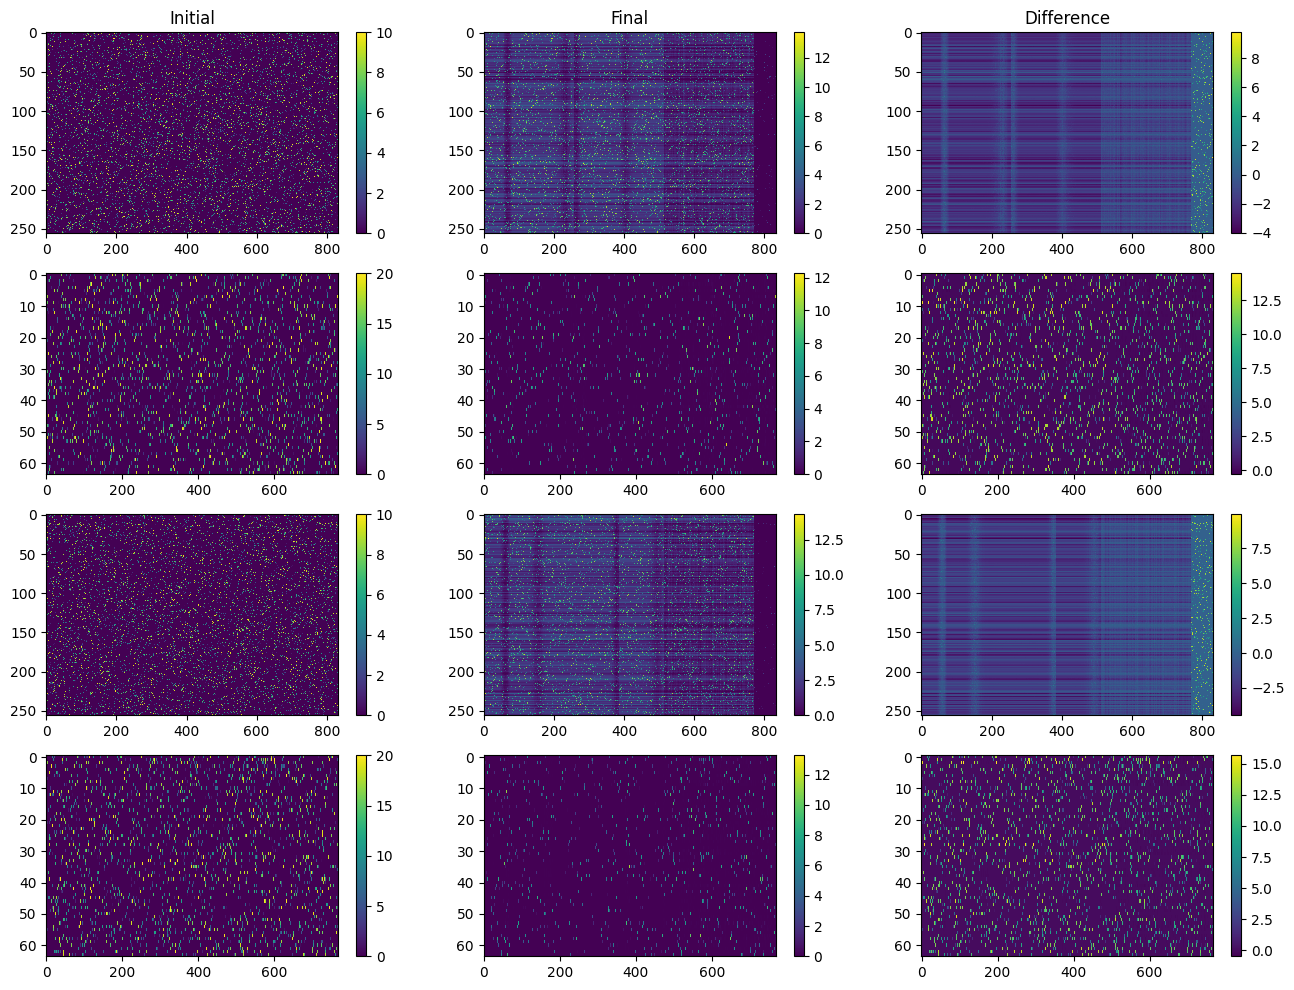

In [ ]:
initial_kernels = (
	jnp.array(brain.A_ex.synapses.kernel.value),
	jnp.array(brain.A_in.synapses.kernel.value),
	jnp.array(brain.B_ex.synapses.kernel.value),
	jnp.array(brain.B_in.synapses.kernel.value),
)
final_brain = spark.merge(graph, state)
final_kernels = (
	jnp.array(final_brain.A_ex.synapses.kernel.value),
	jnp.array(final_brain.A_in.synapses.kernel.value),
	jnp.array(final_brain.B_ex.synapses.kernel.value),
	jnp.array(final_brain.B_in.synapses.kernel.value),
)
plot_kernels(initial_kernels, final_kernels)

In [ ]:
compute_test_plot(
	env, graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, test_epoches=TEST_EPOCHES, output_order=output_spikes_order,
)

100%|██████████| 10/10 [00:44<00:00,  4.43s/it]


In [ ]:
compute_test_plot(
	env, graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, test_epoches=1, output_order=output_spikes_order,
)

In [ ]:
def sample_actions(num_actions, next_obs, graph, state, modulation_decay, steps, unroll=15, output_order=None):
	spikes = []
	actions = []
	env_obs = []
	# A fresh environment
	next_obs, _ = env.reset(seed=42+1)
	env_steps = 0
	next_obs = process_obs(next_obs)
	for i in range(num_actions):
		env_obs.append(next_obs)
		# Model logic
		inputs = {
			'drive': spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)),
			'mod_a_ex': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
			'mod_a_in': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
			'mod_b_ex': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
			'mod_b_in': spark.FloatArray(jnp.array([0], dtype=jnp.float16)),
		}
		out, state, model_spikes = run_model_and_record_scan(
			graph, state, modulation_decay=modulation_decay, steps=steps, 
			unroll=unroll, output_order=output_order, **inputs
		)
		spikes += [model_spikes]
		# Environment logic.
		next_action = int(np.argmax(out['action'].value))
		actions.append(next_action)
		env_steps += 1
	spikes = np.abs(np.concatenate(spikes))
	return spikes, actions, env_obs

def visualize_actions(pre_spikes, pre_actions, post_spikes, post_actions, plot_label):
	import matplotlib.gridspec as gridspec
	fig = plt.figure(figsize=(16, 5))
	gs = gridspec.GridSpec(6, 6)
	ax_spikes_pre = plt.subplot(gs[0:2, 0:4])
	ax_spikes_post = plt.subplot(gs[2:4, 0:4])
	ax_actions = plt.subplot(gs[4:, 0:4])
	ax_freq = plt.subplot(gs[:, 4:])
	fig.suptitle(plot_label)

	ax_spikes_pre.imshow(1-pre_spikes.T[4*128:], cmap='gray', aspect='auto', interpolation='none')
	ax_spikes_pre.set_xlim(0, pre_spikes.shape[0])
	ax_spikes_post.imshow(1-post_spikes.T[4*128:], cmap='gray', aspect='auto', interpolation='none')
	ax_spikes_post.set_xlim(0, post_spikes.shape[0])

	ax_actions.plot(np.linspace(0,pre_spikes.shape[0], len(pre_actions)), pre_actions)
	ax_actions.set_xlim(0, pre_spikes.shape[0])
	ax_actions.plot(np.linspace(0,post_spikes.shape[0], len(post_actions)), post_actions)
	ax_actions.set_xlim(0, post_spikes.shape[0])

	avg_init, avg_end = 4*128, 4*128+256
	a_ex_avg_freq_pre = jnp.mean(pre_spikes[:, avg_init:avg_end])
	a_ex_avg_freq_post = jnp.mean(post_spikes[:, avg_init:avg_end])
	avg_init, avg_end = avg_init+256, avg_end+64
	a_in_avg_freq_pre = jnp.mean(pre_spikes[:, avg_init:avg_end])
	a_in_avg_freq_post = jnp.mean(post_spikes[:, avg_init:avg_end])
	avg_init, avg_end = avg_init+64, avg_end+256
	b_ex_avg_freq_pre = jnp.mean(pre_spikes[:, avg_init:avg_end])
	b_ex_avg_freq_post = jnp.mean(post_spikes[:, avg_init:avg_end])
	avg_init, avg_end = avg_init+256, avg_end+64
	b_in_avg_freq_pre = jnp.mean(pre_spikes[:, avg_init:avg_end])
	b_in_avg_freq_post = jnp.mean(post_spikes[:, avg_init:avg_end])
	ax_freq.bar(np.array([0,1,2,3])-0.2, [a_ex_avg_freq_pre, a_in_avg_freq_pre, b_ex_avg_freq_pre, b_in_avg_freq_pre], width=0.4)
	ax_freq.bar(np.array([0,1,2,3])+0.2, [a_ex_avg_freq_post, a_in_avg_freq_post, b_ex_avg_freq_post, b_in_avg_freq_post], width=0.4)
	ax_freq.set_xticks([0,1,2,3], ['A_ex', 'A_in', 'B_ex', 'B_in'])
	plt.tight_layout()
	plt.show()

def plot_kernels(graph, state):
	current_brain = spark.merge(graph, state)
	current_kernels = (
		jnp.array(current_brain.A_ex.synapses.kernel.value),
		jnp.array(current_brain.A_in.synapses.kernel.value),
		jnp.array(current_brain.B_ex.synapses.kernel.value),
		jnp.array(current_brain.B_in.synapses.kernel.value),
	)
	labels = ('A_ex', 'A_in', 'B_ex', 'B_in')
	ker_fig, ker_ax = plt.subplots(1,4, figsize=(20,4))
	for j in range(4):
		im = ker_ax[j].imshow(current_kernels[j], aspect='auto', interpolation='none')
		ker_ax[j].set_title(labels[j])
		ker_fig.colorbar(im, ax=ker_ax[j])
	ker_fig.suptitle(f'Kernels (Trials: {i})')
	plt.show()

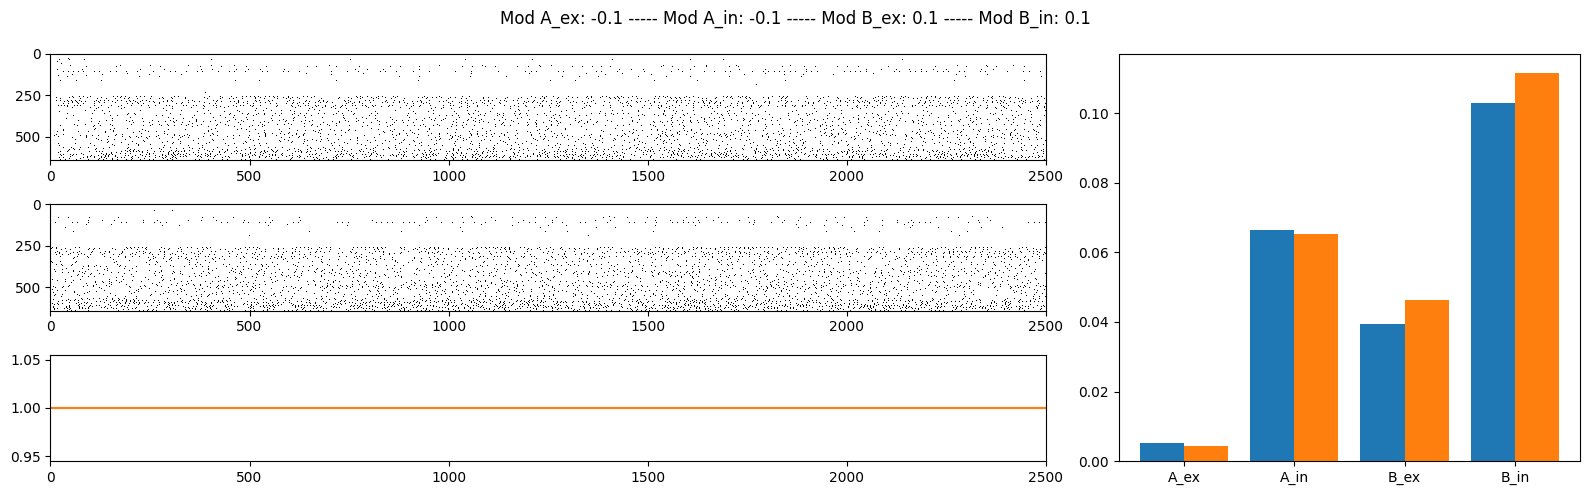

In [ ]:
mod_a_ex, mod_a_in, mod_b_ex, mod_b_in = -0.1, -0.1, 0.1, 0.1#-0.01, -0.01, 0.01, 0.01

# A fresh brain state
next_obs, _ = env.reset(seed=42)
_, state = spark.split((brain))

plot_label = f'Mod A_ex: {mod_a_ex} ----- Mod A_in: {mod_a_in} ----- Mod B_ex: {mod_b_ex} ----- Mod B_in: {mod_b_in}'
pre_spikes, pre_actions, pre_env_obs = sample_actions(
	50, next_obs, graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, output_order=output_spikes_order,
)

# Some classic training loop.
#next_obs, _ = env.reset(seed=42)
for i in range(10):
	inputs = {
		'drive': spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)),
		'mod_a_ex': spark.FloatArray(jnp.array([mod_a_ex], dtype=jnp.float16)),
		'mod_a_in': spark.FloatArray(jnp.array([mod_a_in], dtype=jnp.float16)),
		'mod_b_ex': spark.FloatArray(jnp.array([mod_b_ex], dtype=jnp.float16)),
		'mod_b_in': spark.FloatArray(jnp.array([mod_b_in], dtype=jnp.float16)),
	}
	out, state = run_model_scan(graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, **inputs)

next_obs, _ = env.reset(seed=42)
post_spikes, post_actions, post_env_obs = sample_actions(
	50, next_obs, graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, output_order=output_spikes_order,
)

visualize_actions(pre_spikes, pre_actions, post_spikes, post_actions, plot_label)

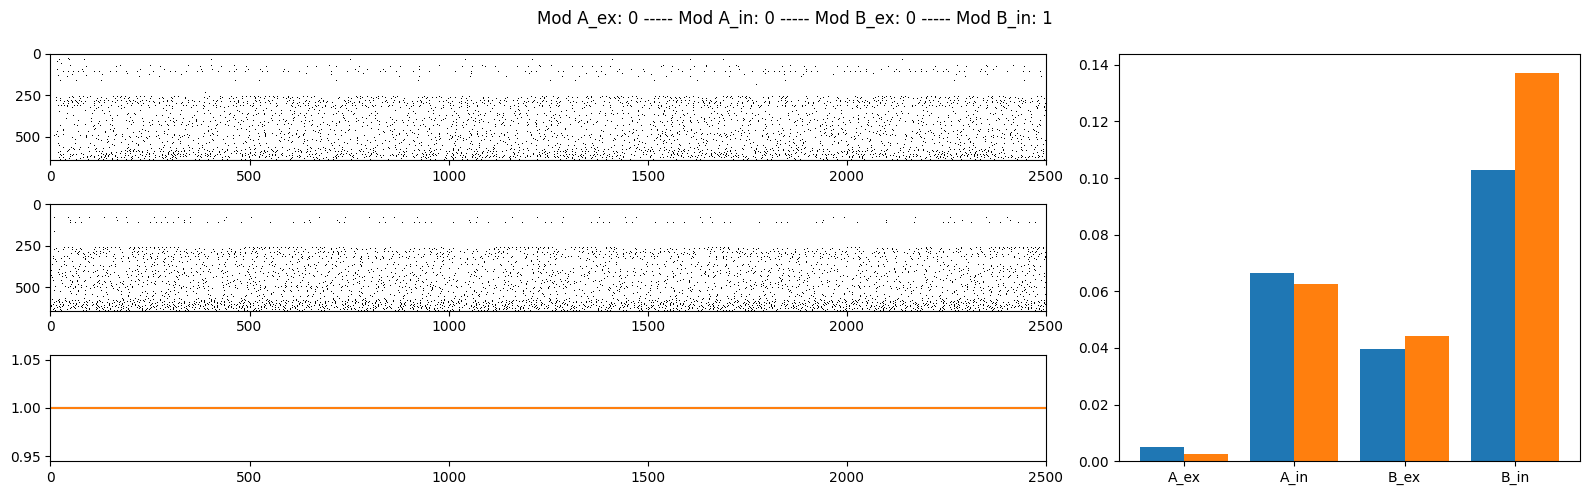

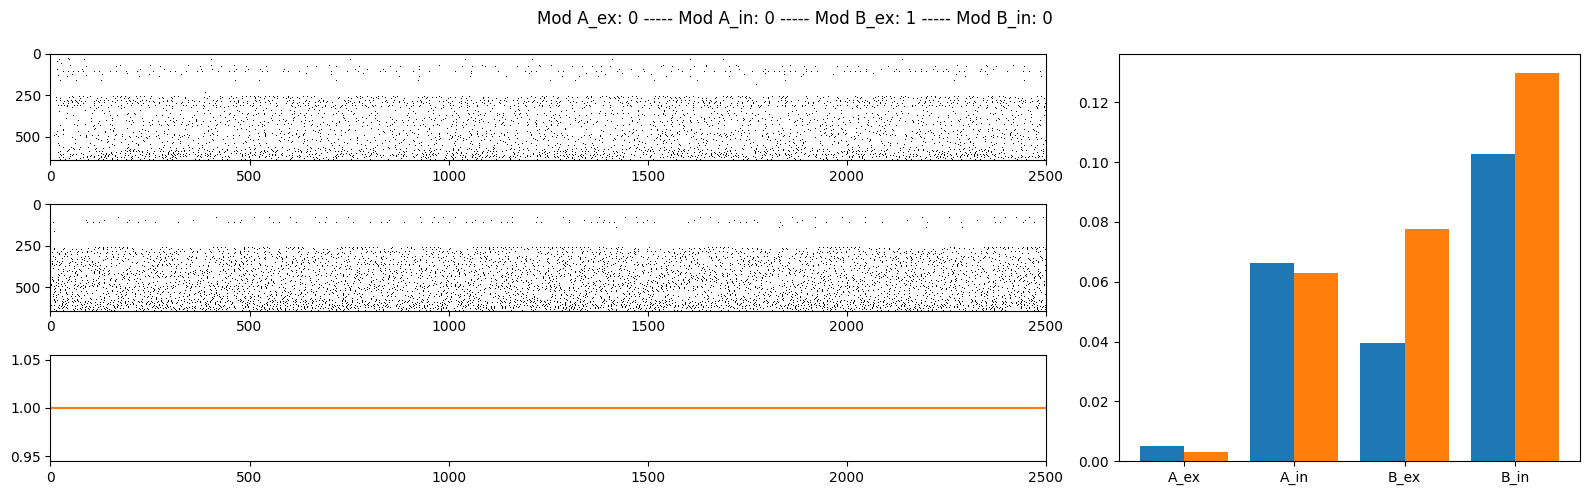

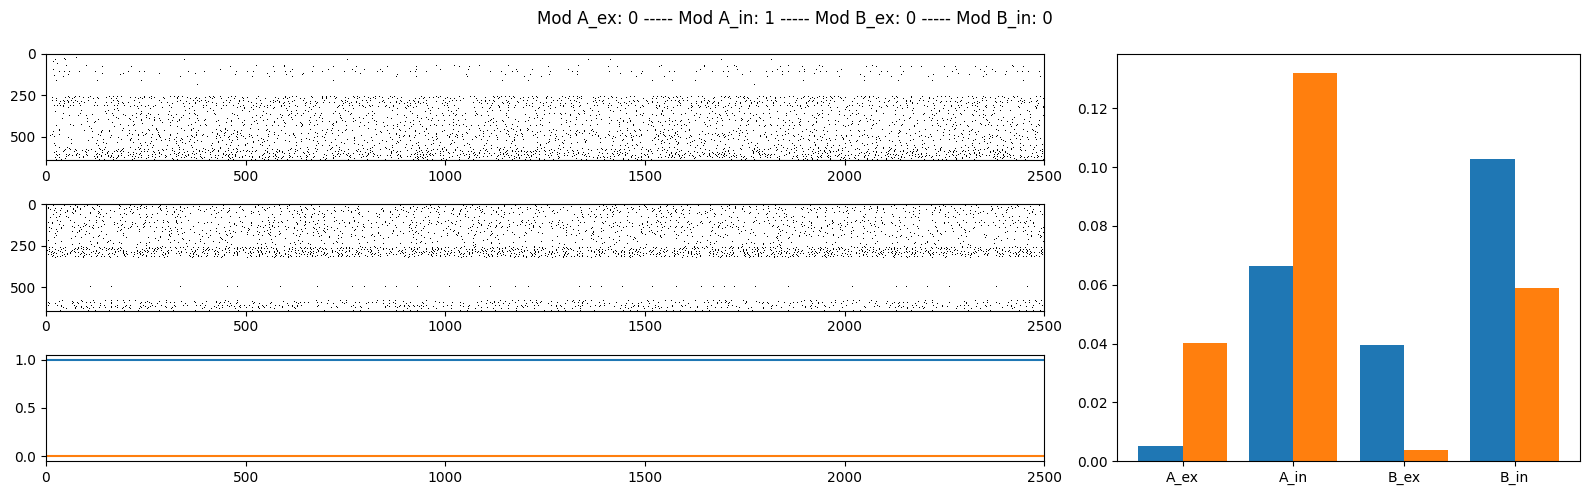

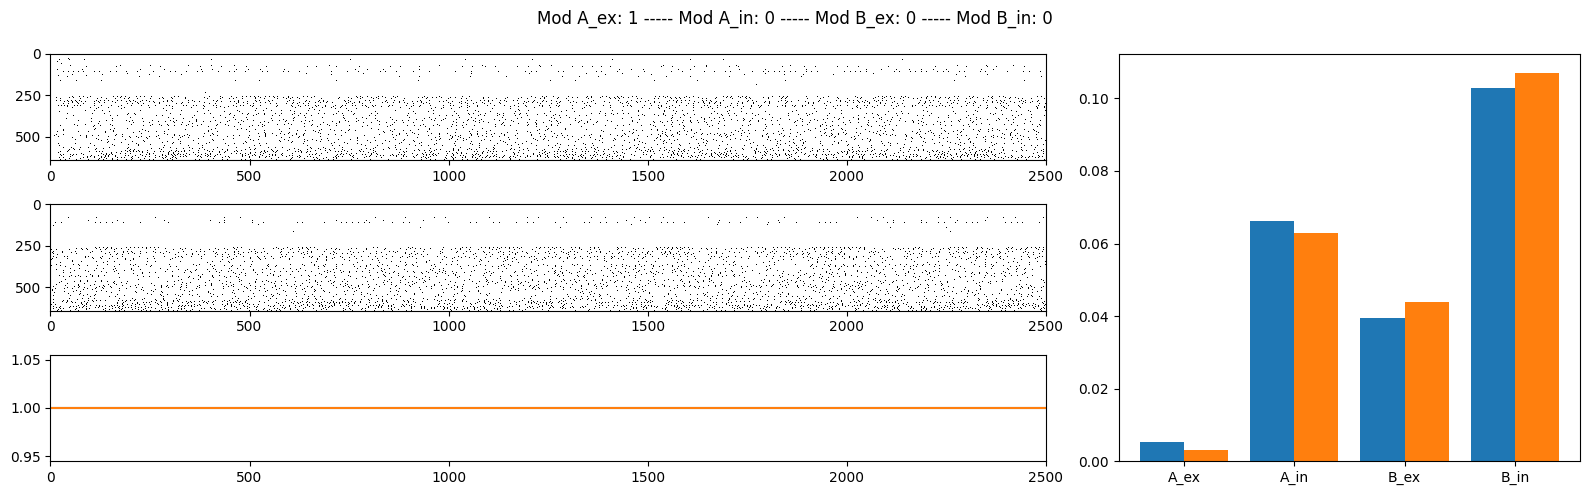

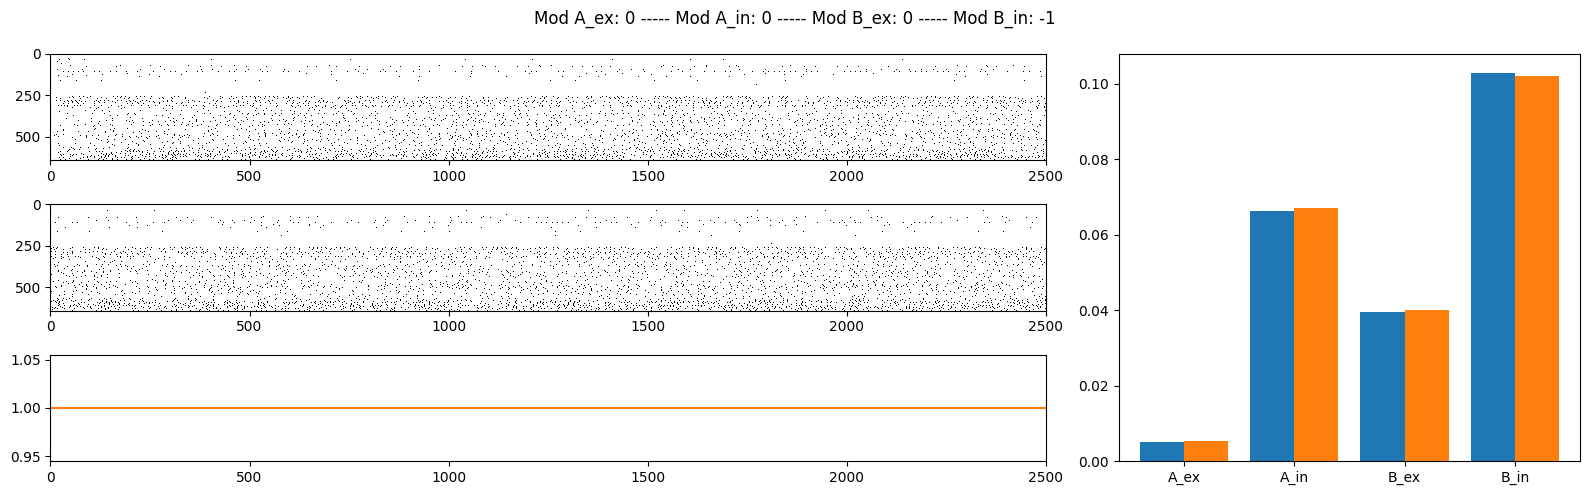

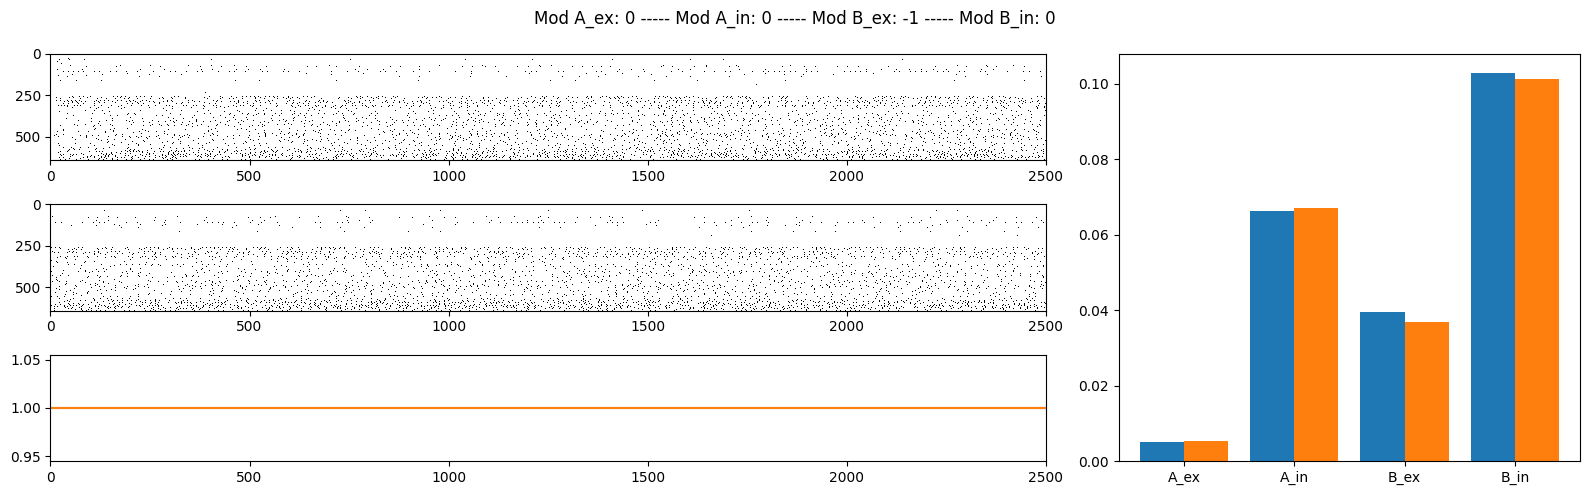

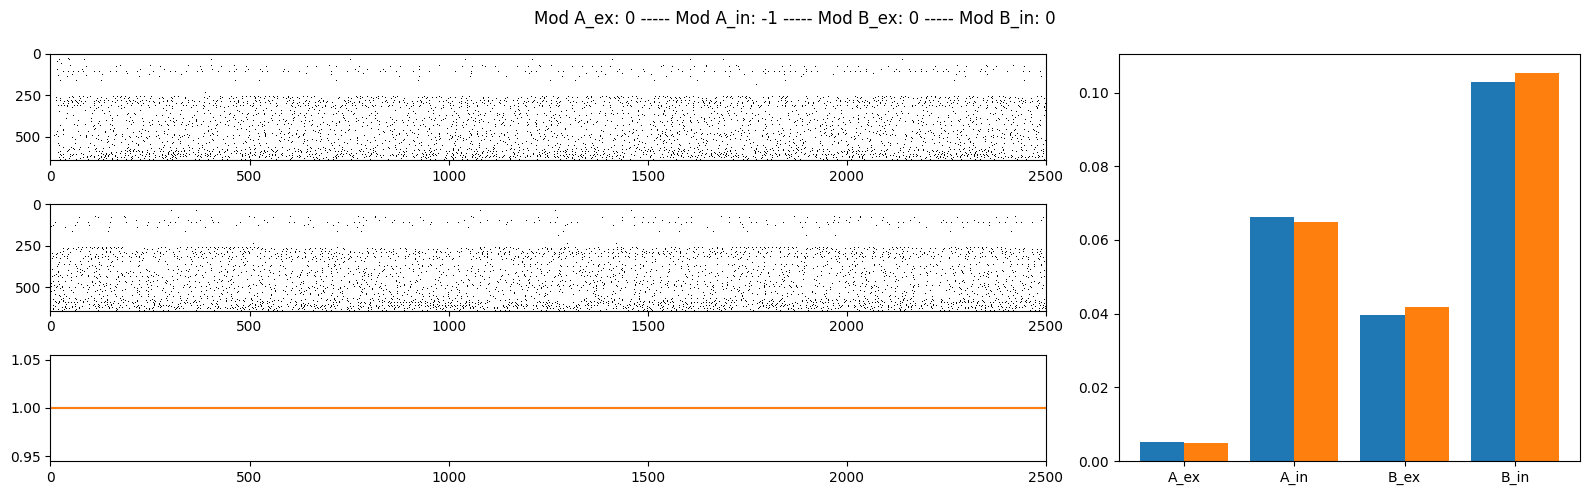

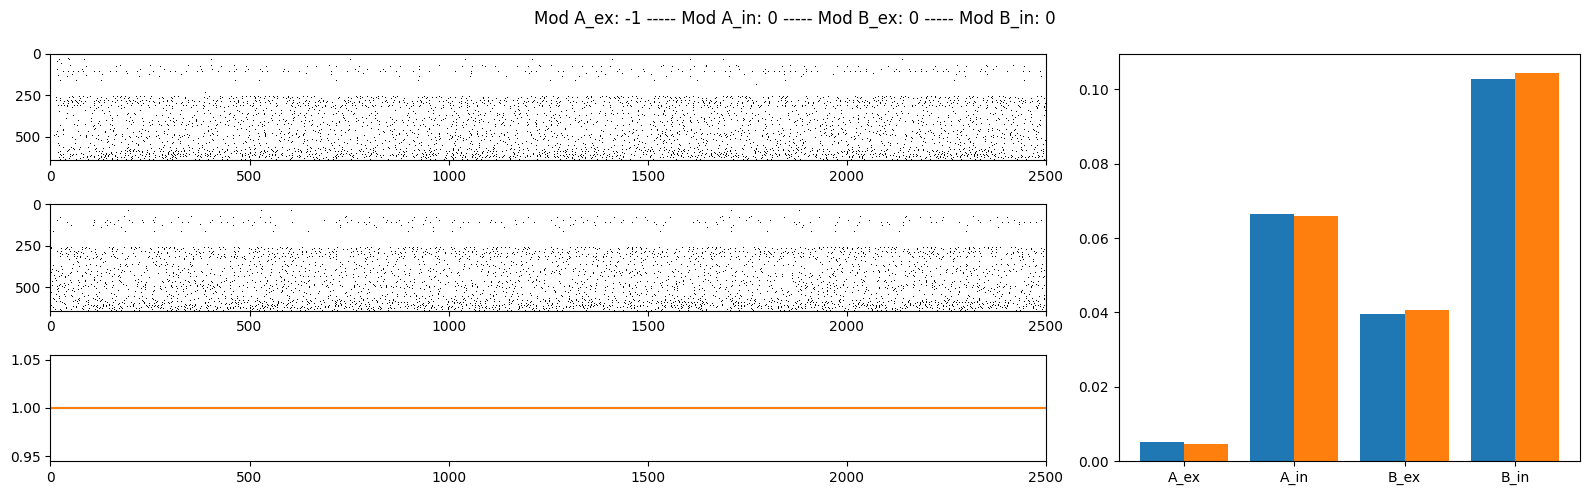

In [ ]:
from itertools import combinations_with_replacement

#combinations = combinations_with_replacement([-1,0,1], 4)
combinations = [
	(0,0,0,1),
	(0,0,1,0),
	(0,1,0,0),
	(1,0,0,0),
	(0,0,0,-1),
	(0,0,-1,0),
	(0,-1,0,0),
	(-1,0,0,0),
]

for mod_a_ex, mod_a_in, mod_b_ex, mod_b_in in combinations:

	# A fresh brain state
	next_obs, _ = env.reset(seed=42)
	_, state = spark.split((brain))

	plot_label = f'Mod A_ex: {mod_a_ex} ----- Mod A_in: {mod_a_in} ----- Mod B_ex: {mod_b_ex} ----- Mod B_in: {mod_b_in}'
	pre_spikes, pre_actions, pre_env_obs = sample_actions(
		50, next_obs, graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, output_order=output_spikes_order,
	)
	
	# Some classic training loop.
	next_obs, _ = env.reset(seed=42)
	for i in range(10):
		inputs = {
			'drive': spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)),
			'mod_a_ex': spark.FloatArray(jnp.array([mod_a_ex], dtype=jnp.float16)),
			'mod_a_in': spark.FloatArray(jnp.array([mod_a_in], dtype=jnp.float16)),
			'mod_b_ex': spark.FloatArray(jnp.array([mod_b_ex], dtype=jnp.float16)),
			'mod_b_in': spark.FloatArray(jnp.array([mod_b_in], dtype=jnp.float16)),
		}
		out, state = run_model_scan(graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, **inputs)

	next_obs, _ = env.reset(seed=42)
	post_spikes, post_actions, post_env_obs = sample_actions(
		50, next_obs, graph, state, modulation_decay=MODULATION_DECAY, steps=STEPS, unroll=UNROLL, output_order=output_spikes_order,
	)

	visualize_actions(pre_spikes, pre_actions, post_spikes, post_actions, plot_label)